# Data for ICU and MV analyses
## - exclude 4 hospitals with no variation in ICU and MV
## - replace non-plausible values for missing
## - create df_iacov_model_lean_14hosp.csv

First we import the required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# para evitarmos a exibição dos dados em notacao científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#comment next line to not use MLFlow for cleaning data
from MLFlow_Classification import *
from MLFlow_Utils import *

C:\Users\carin\AppData\Local\Temp\ipykernel_14172\2463766658.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Put csv in same folder as this notebook
dataset = pd.read_csv("df_iacov_en.csv", delimiter=";")
df_iacov_model = pd.DataFrame(dataset)
df_iacov_model.shape

(8477, 65)

In [3]:
df_iacov_model.columns

Index(['city_hospital', 'cd_patient', 'hospital_time', 'age', 'race', 'braden',
       'heart_rate', 'resp_rate', 'sys_press', 'dias_press', 'mean_press',
       'temp', 'saturation', 'weight', 'height', 'hemoglobin', 'platelets',
       'hematocrit', 'red_cells_count', 'hcm', 'rdw', 'mcv', 'leukocytes',
       'neutrophil', 'lymphocytes', 'neutr_lymph_ratio', 'lymph_crp_ratio',
       'basophils', 'eosinophils', 'monocytes', 'crp', 'albumin', 'ldh', 'alt',
       'ast', 'total_bilirubin', 'direct_bilirubin', 'indirect_bilirubin',
       'urea', 'sodium', 'potassium', 'creatinine', 'troponin', 'd_dimer',
       'venous_lactate', 'cpk', 'inr', 'aptt', 'arterial_lactate', 'gas_ph',
       'gaso_po2', 'gas_paco2', 'gas_hco3', 'gas_be', 'gas_so2', 'magnesium',
       'calcium_ionised', 'total_calcium', 'glucose', 'state', 'region', 'icu',
       'death', 'mv', 'male'],
      dtype='object')

In [4]:
# Distribution of hospitals across the 5 regions 
crosstab_hospital_region = pd.crosstab(df_iacov_model['city_hospital'], df_iacov_model['region'])
crosstab_hospital_region

region,CENTROOESTE,NORDESTE,NORTE,SUDESTE,SUL
city_hospital,,,,,
AMAZONAS_HUGV,0,0,47,0,0
CEARA_HUWC,0,73,0,0,0
CEARA_UNIMED,0,845,0,0,0
HC_USP,0,0,0,1500,0
HEVV,0,0,0,56,0
HMV_POA_02,0,0,0,0,456
HOSPGRUPOSANTA,281,0,0,0,0
HOSPPORTUGUES_SALVADOR,0,1359,0,0,0
HOSPSANTACASASP_FULL,0,0,0,1776,0


In [5]:
df_iacov_model.head(5)

,city_hospital,cd_patient,hospital_time,age,race,braden,heart_rate,resp_rate,sys_press,dias_press,...,magnesium,calcium_ionised,total_calcium,glucose,state,region,icu,death,mv,male
0,AMAZONAS_HUGV,60455011.000,10.000,56.000,Pardo,NaN,89.000,23.000,130.000,80.000,...,NaN,NaN,NaN,NaN,AM,NORTE,1,0,1,1.000
1,AMAZONAS_HUGV,61429940.000,10.000,61.000,Pardo,NaN,86.000,18.000,172.000,75.000,...,2.100,1.150,NaN,NaN,AM,NORTE,1,1,1,1.000
2,AMAZONAS_HUGV,61418893.000,79.000,28.000,Pardo,NaN,80.000,30.000,117.000,56.000,...,2.500,1.210,7.280,NaN,AM,NORTE,1,0,1,1.000
3,AMAZONAS_HUGV,61430039.000,15.000,69.000,Pardo,NaN,68.000,NaN,149.000,81.000,...,NaN,NaN,NaN,NaN,AM,NORTE,0,0,0,0.000
4,AMAZONAS_HUGV,61429841.000,16.000,66.000,Pardo,NaN,67.000,NaN,124.000,75.000,...,2.100,NaN,7.770,NaN,AM,NORTE,1,0,1,1.000


## Assign binary outcome to be predicted

### Maintain essential variables (LEAN Model) - include three outcomes death, ICU and MV

In [6]:
#22 predictors + outcome (death, icu, vm) + state + region
df_iacov_model_lean = df_iacov_model[['city_hospital'
                                      ,'age'
                                      ,'male'
                                      ,'race'
                                      ,'heart_rate'
                                      ,'resp_rate'
                                      ,'sys_press'
                                      ,'dias_press'
                                      ,'mean_press'
                                      ,'temp'
                                      ,'hemoglobin'
                                      ,'platelets'
                                      ,'hematocrit'
                                      ,'red_cells_count'
                                      ,'hcm'
                                      ,'rdw'
                                      ,'mcv'
                                      ,'leukocytes'
                                      ,'neutrophil'
                                      ,'lymphocytes'
                                      ,'basophils'
                                      ,'eosinophils'
                                      ,'monocytes'
                                      ,'crp'
                                      ,'death'
                                      ,'icu'
                                      ,'mv'
                                      ,'state'
                                      ,'region']]
df_iacov_model_lean.shape

(8477, 29)

In [7]:
df_iacov_model_lean.city_hospital.value_counts()

city_hospital
HOSPSANTACASASP_FULL          1776
HC_USP                        1500
HOSPPORTUGUES_SALVADOR        1359
CEARA_UNIMED                   845
HRL_2021_02                    539
HMV_POA_02                     456
RIO_DE_JANEIRO_UNIMED          449
RIO_DE_JANEIRO_HUCFF           296
HOSPGRUPOSANTA                 281
HOSPSANTAJULIA_MANAUS          247
HOSPSANTACATARINABLUMENAU      148
HOSPSAOFRANCISCO_MOGIGUACU     124
PERNAMBUCO_FULL                112
PELOTAS                         91
HUTRIN_2021_02                  78
CEARA_HUWC                      73
HEVV                            56
AMAZONAS_HUGV                   47
Name: count, dtype: int64

In [8]:
# crosstable to evaluate frequency of observations according to hospital and outcome ICU
crosstab_hospital_icu = pd.crosstab(df_iacov_model_lean['city_hospital'], df_iacov_model_lean['icu'])
crosstab_hospital_icu

icu,0,1
city_hospital,,
AMAZONAS_HUGV,13,34
CEARA_HUWC,42,31
CEARA_UNIMED,660,185
HC_USP,452,1048
HEVV,32,24
HMV_POA_02,319,137
HOSPGRUPOSANTA,0,281
HOSPPORTUGUES_SALVADOR,1114,245
HOSPSANTACASASP_FULL,1776,0


In [9]:
# crosstable to evaluate frequency of observations according to hospital and outcome MV
crosstab_hospital_mv = pd.crosstab(df_iacov_model_lean['city_hospital'], df_iacov_model_lean['mv'])
crosstab_hospital_mv

mv,0,1
city_hospital,,
AMAZONAS_HUGV,20,27
CEARA_HUWC,41,32
CEARA_UNIMED,716,129
HC_USP,835,665
HEVV,43,13
HMV_POA_02,371,85
HOSPGRUPOSANTA,248,33
HOSPPORTUGUES_SALVADOR,1240,119
HOSPSANTACASASP_FULL,1776,0


### Exclude hospitals with no variation in the outcome ICU or MV

In [10]:
categoria1='HOSPSANTACASASP_FULL'
categoria2='HOSPGRUPOSANTA'
categoria3='HUTRIN_2021_02'
categoria4='RIO_DE_JANEIRO_HUCFF'
df_iacov_model_lean['excluir'] = (df_iacov_model_lean['city_hospital'] == categoria1) | (df_iacov_model_lean['city_hospital'] == categoria2) | (df_iacov_model_lean['city_hospital'] == categoria3) | (df_iacov_model_lean['city_hospital'] == categoria4)

if df_iacov_model_lean['excluir'].any():
    df_iacov_model_lean_14hosp = df_iacov_model_lean[df_iacov_model_lean['excluir'] == False]

In [11]:
df_iacov_model_lean_14hosp.shape

(6046, 30)

In [12]:
df_iacov_model_lean_14hosp['city_hospital'].value_counts()

city_hospital
HC_USP                        1500
HOSPPORTUGUES_SALVADOR        1359
CEARA_UNIMED                   845
HRL_2021_02                    539
HMV_POA_02                     456
RIO_DE_JANEIRO_UNIMED          449
HOSPSANTAJULIA_MANAUS          247
HOSPSANTACATARINABLUMENAU      148
HOSPSAOFRANCISCO_MOGIGUACU     124
PERNAMBUCO_FULL                112
PELOTAS                         91
CEARA_HUWC                      73
HEVV                            56
AMAZONAS_HUGV                   47
Name: count, dtype: int64

In [13]:
# Distribution of hospitals across the 5 regions - after exclusion of 4 hospitals
crosstab_hospital_region2 = pd.crosstab(df_iacov_model_lean_14hosp['city_hospital'], df_iacov_model_lean_14hosp['region'])
crosstab_hospital_region2

region,CENTROOESTE,NORDESTE,NORTE,SUDESTE,SUL
city_hospital,,,,,
AMAZONAS_HUGV,0,0,47,0,0
CEARA_HUWC,0,73,0,0,0
CEARA_UNIMED,0,845,0,0,0
HC_USP,0,0,0,1500,0
HEVV,0,0,0,56,0
HMV_POA_02,0,0,0,0,456
HOSPPORTUGUES_SALVADOR,0,1359,0,0,0
HOSPSANTACATARINABLUMENAU,0,0,0,0,148
HOSPSANTAJULIA_MANAUS,0,0,247,0,0


## Calculate the frequency of patients who died without going through ICU (availability?)

In [14]:
# 125/6046 - 2,1% of all patients died without going throuh ICU
crosstab_icu_death = pd.crosstab(index=df_iacov_model_lean_14hosp['icu'], columns=df_iacov_model_lean_14hosp['death'])
crosstab_icu_death

death,0,1
icu,,
0,3165,125
1,1469,1287


In [15]:
# frequency of patients who who died without going through ICU - per hospital
crosstab_icu_death_perhospital = pd.crosstab(index=[df_iacov_model_lean_14hosp['city_hospital'],df_iacov_model_lean_14hosp['icu']], columns=df_iacov_model_lean_14hosp['death'])
crosstab_icu_death_perhospital

death                              0    1
city_hospital              icu           
AMAZONAS_HUGV              0      10    3
                           1      21   13
CEARA_HUWC                 0      39    3
                           1      13   18
CEARA_UNIMED               0     645   15
                           1      90   95
HC_USP                     0     412   40
                           1     551  497
HEVV                       0      26    6
                           1      17    7
HMV_POA_02                 0     307   12
                           1     102   35
HOSPPORTUGUES_SALVADOR     0    1100   14
                           1     165   80
HOSPSANTACATARINABLUMENAU  0     126    1
                           1      12    9
HOSPSANTAJULIA_MANAUS      0     170    2
                           1      39   36
HOSPSAOFRANCISCO_MOGIGUACU 0      93    4
                           1      14   13
HRL_2021_02                0      12   13
                           1     199  315
PELOTAS                    0      42    3
                           1      15   31
PERNAMBUCO_FULL            0      41    5
                           1      30   36
RIO_DE_JANEIRO_UNIMED      0     142    4
                           1     201  102

## Calculate the frequency of patients who died without going through MV (availability?)

In [16]:
# 312/6046 - 5,2% of all patients died without going through MV 
crosstab_mv_death = pd.crosstab(index=df_iacov_model_lean_14hosp['mv'], columns=df_iacov_model_lean_14hosp['death'])
crosstab_mv_death

death,0,1
mv,,
0,4031,312
1,603,1100


In [17]:
# who died without going through MV - per hospital
crosstab_mv_death_perhospital = pd.crosstab(index=[df_iacov_model_lean_14hosp['city_hospital'],df_iacov_model_lean_14hosp['mv']], columns=df_iacov_model_lean_14hosp['death'])
crosstab_mv_death_perhospital

death                             0    1
city_hospital              mv           
AMAZONAS_HUGV              0     18    2
                           1     13   14
CEARA_HUWC                 0     39    2
                           1     13   19
CEARA_UNIMED               0    690   26
                           1     45   84
HC_USP                     0    686  149
                           1    277  388
HEVV                       0     37    6
                           1      6    7
HMV_POA_02                 0    354   17
                           1     55   30
HOSPPORTUGUES_SALVADOR     0   1214   26
                           1     51   68
HOSPSANTACATARINABLUMENAU  0    134    3
                           1      4    7
HOSPSANTAJULIA_MANAUS      0    195    6
                           1     14   32
HOSPSAOFRANCISCO_MOGIGUACU 0    101    3
                           1      6   14
HRL_2021_02                0    182   50
                           1     29  278
PELOTAS                    0     49    8
                           1      8   26
PERNAMBUCO_FULL            0     56    5
                           1     15   36
RIO_DE_JANEIRO_UNIMED      0    276    9
                           1     67   97

## Box-plot to evaluate outliers

In [18]:
# List of numeric variables
numeric_features = ['age','heart_rate','resp_rate','sys_press','dias_press','mean_press','temp','hemoglobin','platelets','hematocrit',
                    'red_cells_count','hcm','rdw','mcv','leukocytes','neutrophil','lymphocytes','basophils','eosinophils','monocytes','crp']

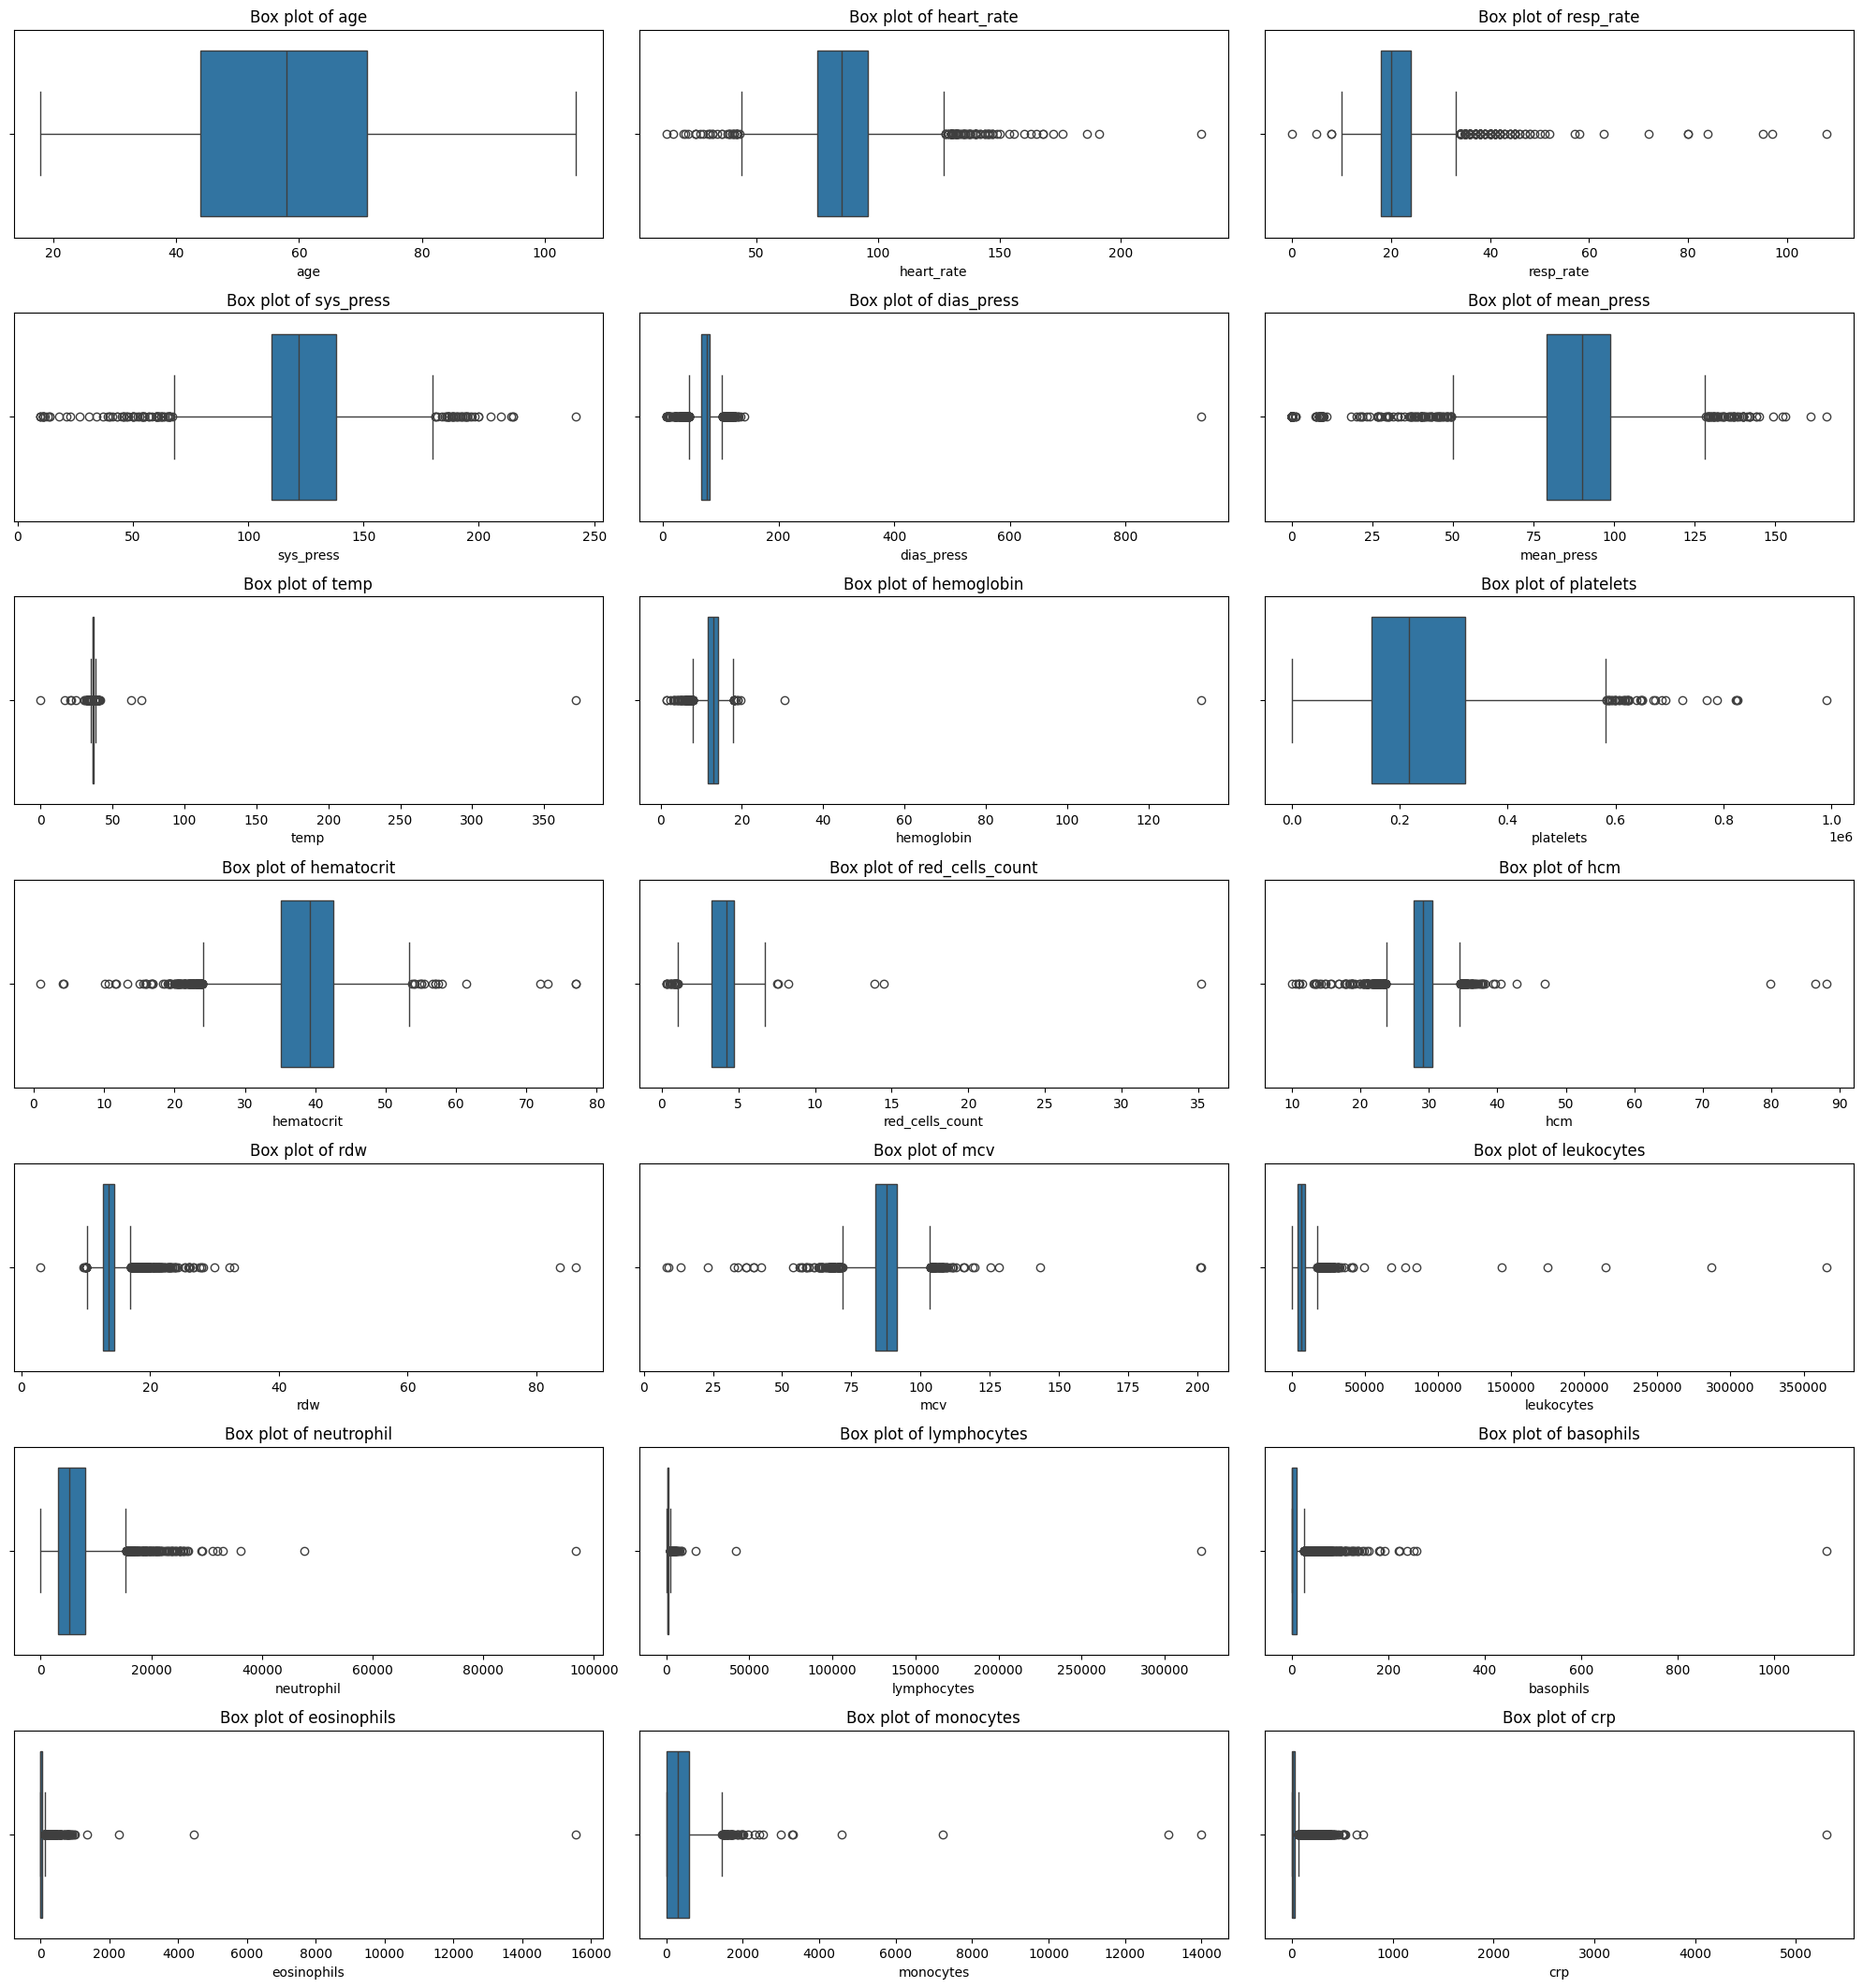

In [19]:
# Setting up the matplotlib figure
plt.figure(figsize=(20, 30))

# Plotting box plots for each numeric feature
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(10, 3, i)  # Use a flat index and start from 1
    
    # Creating a box plot for the current feature
    sns.boxplot(x=df_iacov_model_lean_14hosp[feature])
    
    # Adding the feature name as title
    plt.title(f'Box plot of {feature}')

# Adjusting the layout
plt.tight_layout()
plt.show()

In [20]:
# print 10 higher values
for feature in numeric_features:
    print(str(df_iacov_model_lean_14hosp.nlargest(10,feature)[[feature,'city_hospital']]) + '\n')

         age           city_hospital
8354 105.000              HMV_POA_02
518  100.000            CEARA_UNIMED
8425 100.000              HMV_POA_02
768   99.000            CEARA_UNIMED
3379  99.000  HOSPPORTUGUES_SALVADOR
7594  99.000             HRL_2021_02
8351  99.000              HMV_POA_02
302   98.000            CEARA_UNIMED
1842  98.000                  HC_USP
540   97.000            CEARA_UNIMED

      heart_rate          city_hospital
7771     233.000            HRL_2021_02
1441     191.000                 HC_USP
8035     186.000             HMV_POA_02
349      176.000           CEARA_UNIMED
19       172.000          AMAZONAS_HUGV
928      168.000           CEARA_UNIMED
5481     168.000  RIO_DE_JANEIRO_UNIMED
1285     165.000                 HC_USP
7789     163.000            HRL_2021_02
7775     160.000            HRL_2021_02

      resp_rate          city_hospital
1107    108.000                 HC_USP
1389     97.000                 HC_USP
7796     95.000            HRL_202

### Replacing higher outliers with NaN according the criterion: the maximum is at least the double of the next observation

In [21]:
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['dias_press'] == 931.000, 'dias_press'] = None
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['hemoglobin'] == 133.000, 'hemoglobin'] = None
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['red_cells_count'] == 35.200, 'red_cells_count'] = None
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['neutrophil'] == 96700.000, 'neutrophil'] = None
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['lymphocytes'] == 322010.000, 'lymphocytes'] = None
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['basophils'] == 1110.000, 'basophils'] = None
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['eosinophils'] == 15560.000, 'eosinophils'] = None
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['monocytes'] == 14000.000, 'monocytes'] = None
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['monocytes'] == 13134.000, 'monocytes'] = None
df_iacov_model_lean_14hosp.loc[df_iacov_model_lean_14hosp['crp'] == 5306.000, 'crp'] = None

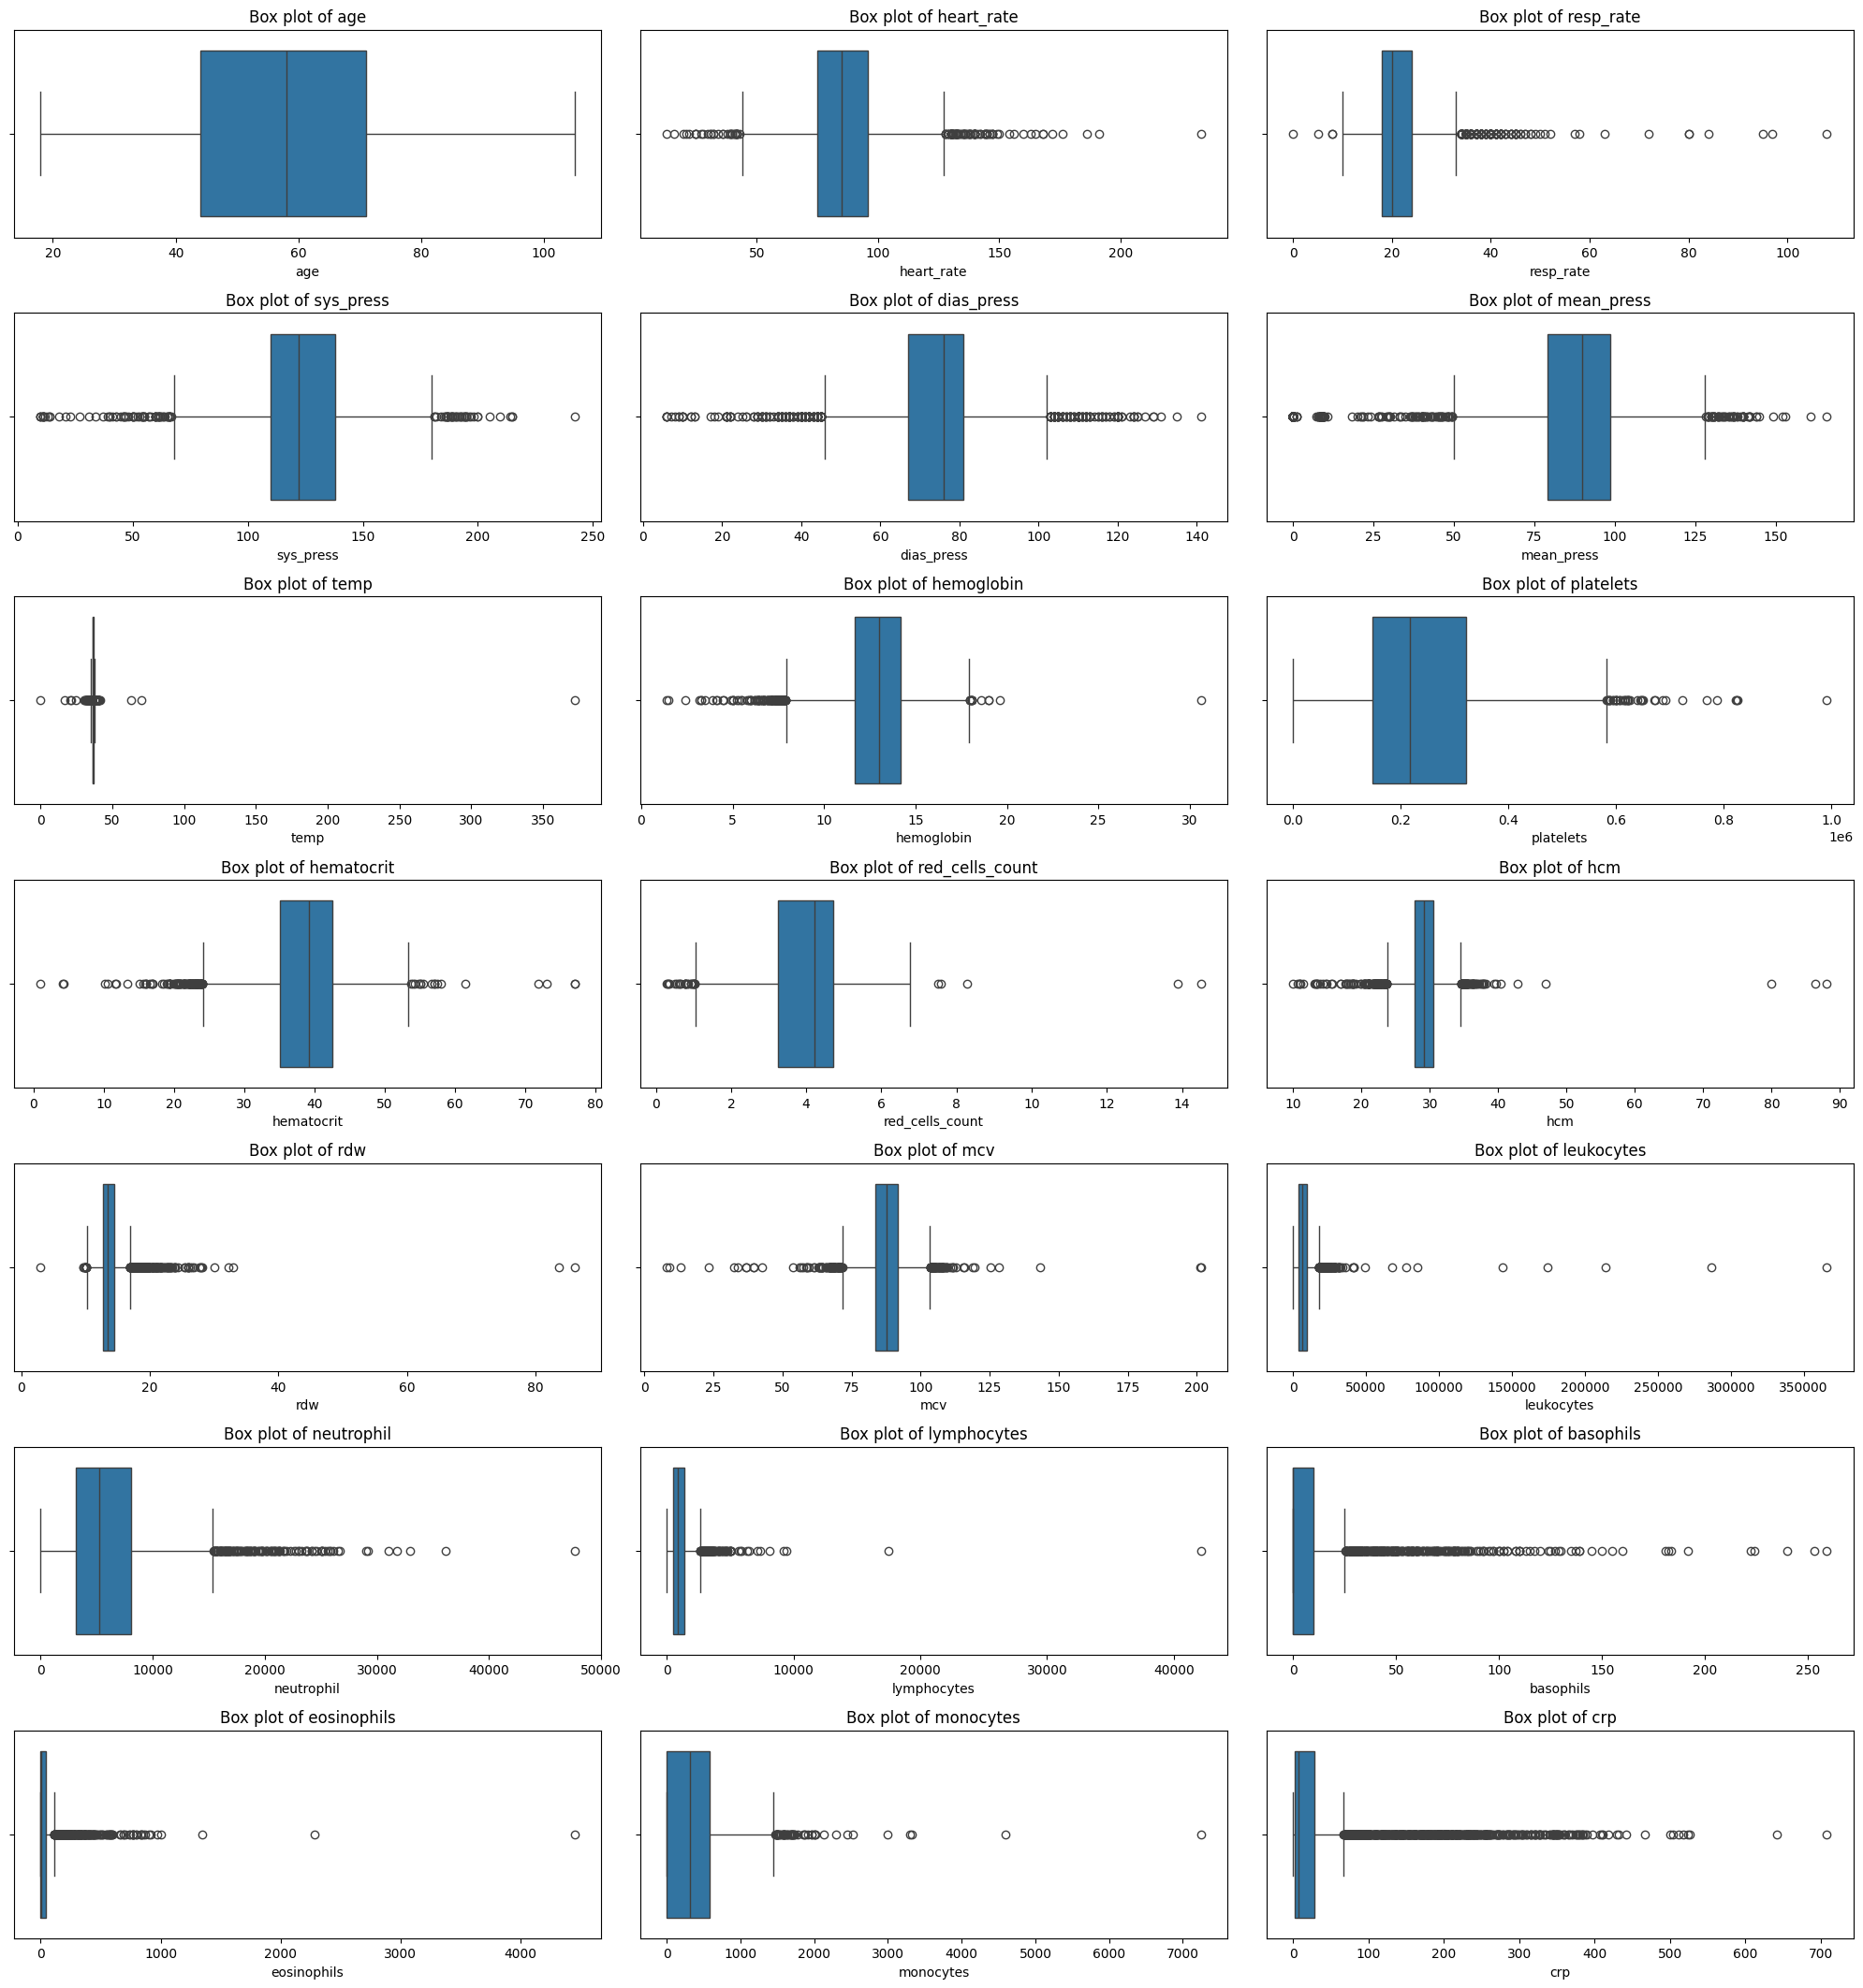

In [22]:
# New box-plots after removing non-plausible values

# Setting up the matplotlib figure
plt.figure(figsize=(20, 30))

# Plotting box plots for each numeric feature
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(10, 3, i)  # Use a flat index and start from 1
    
    # Creating a box plot for the current feature
    sns.boxplot(x=df_iacov_model_lean_14hosp[feature])
    
    # Adding the feature name as title
    plt.title(f'Box plot of {feature}')

# Adjusting the layout
plt.tight_layout()
plt.show()

In [23]:
df_iacov_model_lean_14hosp.to_csv('df_iacov_model_lean_14hosp.csv', sep=';', index=False)

In [24]:
df_iacov_model_lean_14hosp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,6046.000,57.521,17.869,18.000,44.000,58.000,71.000,105.000
male,6046.000,0.539,0.499,0.000,0.000,1.000,1.000,1.000
heart_rate,5237.000,85.689,17.209,13.000,75.000,85.000,96.000,233.000
resp_rate,4589.000,21.881,6.380,0.000,18.000,20.000,24.000,108.000
sys_press,4710.000,124.054,22.791,10.000,110.000,122.000,138.000,242.000
dias_press,4721.000,74.608,14.626,6.000,67.000,76.000,81.000,141.000
mean_press,4680.000,83.731,28.475,0.000,78.981,90.000,98.648,166.000
temp,4873.000,36.430,4.976,0.000,36.000,36.300,36.800,372.000
hemoglobin,4142.000,12.752,2.189,1.400,11.692,13.000,14.200,30.600
platelets,5302.000,235701.617,143771.202,7.000,148000.000,217000.000,321750.000,992000.000


## Descriptive analyses for 14 hospitals - Table 1 for new paper

### Number of patients by region, ICU and MV

In [4]:
import pandas as pd
import numpy as np

In [5]:
df_iacov_model_lean_14hosp = pd.read_csv("df_iacov_model_lean_14hosp.csv", delimiter=";")

In [9]:
df_iacov_model_lean_14hosp['male'].value_counts(normalize = True)

male
1.0    0.538538
0.0    0.461462
Name: proportion, dtype: float64

In [12]:
df_iacov_model_lean_14hosp['race'].value_counts(normalize = True)
#df_iacov_model_lean_14hosp['race'].value_counts()

race
N/a        0.558386
Branco     0.288621
Pardo      0.124711
Preto      0.025802
Amarelo    0.002481
Name: proportion, dtype: float64

In [13]:
df_iacov_model_lean_14hosp['age'].mean()

57.52102381739993

In [14]:
df_iacov_model_lean_14hosp['age'].std()

17.869007644631505

In [6]:
# Cross table - region x icu
crosstab_region_icu = pd.crosstab(df_iacov_model_lean_14hosp['region'], df_iacov_model_lean_14hosp['icu'],margins=True)
crosstab_region_icu

icu,0,1,All
region,,,
CENTROOESTE,25,514,539
NORDESTE,1862,527,2389
NORTE,185,109,294
SUDESTE,727,1402,2129
SUL,491,204,695
All,3290,2756,6046


In [70]:
# Cross table - region x mv
crosstab_region_mv = pd.crosstab(df_iacov_model_lean_14hosp['region'], df_iacov_model_lean_14hosp['mv'], margins=True)
crosstab_region_mv

mv,0,1,All
region,,,
CENTROOESTE,232,307,539
NORDESTE,2058,331,2389
NORTE,221,73,294
SUDESTE,1267,862,2129
SUL,565,130,695
All,4343,1703,6046


### Descriptives for age and temp - by region, ICU and MV

In [71]:
# round mean and std
def mean_r(x):
    return round(np.mean(x), 1)
def std_r(x):
    return round(np.std(x), 1)

In [72]:
# Table for descriptive measures of age and temp by region
tab_age_temp_byregion = pd.pivot_table(
    df_iacov_model_lean_14hosp, 
    values=['age', 'temp'],
    index=['region'],
    aggfunc={'age': [mean_r, std_r], 'temp': [mean_r, std_r]},
)
print(tab_age_temp_byregion)

               age          temp       
            mean_r  std_r mean_r  std_r
region                                 
CENTROOESTE 58.000 15.800 36.900 14.800
NORDESTE    54.600 19.000 36.400  1.100
NORTE       56.700 16.800 36.300  0.700
SUDESTE     60.600 16.600 36.400  1.000
SUL         58.000 18.200 36.600  2.400


In [73]:
# Table for descriptive measures of age and temp by region and ICU
tab_age_temp_byregion_icu = pd.pivot_table(
    df_iacov_model_lean_14hosp, 
    values=['age', 'temp'],
    index=['region'],
    aggfunc={'age': [mean_r, std_r], 'temp': [mean_r, std_r]},
    columns=['icu'],
)
print(tab_age_temp_byregion_icu)

               age                        temp                    
            mean_r         std_r        mean_r        std_r       
icu              0      1      0      1      0      1     0      1
region                                                            
CENTROOESTE 60.000 57.900 17.200 15.700 35.900 36.900 1.200 15.100
NORDESTE    51.600 65.400 18.400 16.900 36.300 36.400 0.800  1.600
NORTE       52.800 63.400 16.400 15.200 36.300 36.400 0.600  0.800
SUDESTE     57.000 62.500 17.800 15.600 36.400 36.300 0.800  1.000
SUL         54.100 67.200 17.600 16.200 36.600 36.500 2.700  1.100


In [74]:
# Table for descriptive measures of age and temp by region and MV
tab_age_temp_byregion_mv = pd.pivot_table(
    df_iacov_model_lean_14hosp, 
    values=['age', 'temp'],
    index=['region'],
    aggfunc={'age': [mean_r, std_r], 'temp': [mean_r, std_r]},
    columns=['mv'],
)
print(tab_age_temp_byregion_mv)

               age                        temp                    
            mean_r         std_r        mean_r        std_r       
mv               0      1      0      1      0      1     0      1
region                                                            
CENTROOESTE 54.400 60.700 15.400 15.500 36.300 37.200 2.500 19.300
NORDESTE    52.800 66.200 18.700 15.900 36.300 36.500 0.800  1.900
NORTE       54.100 64.500 16.600 14.800 36.300 36.400 0.700  0.800
SUDESTE     59.600 62.100 17.400 15.200 36.400 36.400 0.900  1.100
SUL         55.600 68.000 17.800 15.900 36.800 35.900 0.900  5.000


### % Male - by region, ICU and MV

In [75]:
# Cross table - % of female/male for patients by region
crosstab_male_perregion = pd.crosstab(index=df_iacov_model_lean_14hosp['region'], columns=df_iacov_model_lean_14hosp['male'], normalize='index')
crosstab_male_perregion

male,0.000,1.000
region,,
CENTROOESTE,0.378,0.622
NORDESTE,0.514,0.486
NORTE,0.432,0.568
SUDESTE,0.438,0.562
SUL,0.427,0.573


In [76]:
# Cross table - % of female/male for patients who went to ICU by region
crosstab_male_icu_perregion = pd.crosstab(index=[df_iacov_model_lean_14hosp['region'], df_iacov_model_lean_14hosp['icu']], columns=df_iacov_model_lean_14hosp['male'], normalize='index')
crosstab_male_icu_perregion

male             0.000  1.000
region      icu              
CENTROOESTE 0    0.360  0.640
            1    0.379  0.621
NORDESTE    0    0.523  0.477
            1    0.486  0.514
NORTE       0    0.465  0.535
            1    0.376  0.624
SUDESTE     0    0.503  0.497
            1    0.404  0.596
SUL         0    0.448  0.552
            1    0.377  0.623

In [61]:
# Cross table - % of female/male for patients who went to MV by region
crosstab_male_mv_perregion = pd.crosstab(index=[df_iacov_model_lean_14hosp['region'], df_iacov_model_lean_14hosp['mv']], columns=df_iacov_model_lean_14hosp['male'], normalize='index')
crosstab_male_mv_perregion

male            0.000  1.000
region      mv              
CENTROOESTE 0   0.349  0.651
            1   0.401  0.599
NORDESTE    0   0.524  0.476
            1   0.453  0.547
NORTE       0   0.462  0.538
            1   0.342  0.658
SUDESTE     0   0.470  0.530
            1   0.391  0.609
SUL         0   0.437  0.563
            1   0.385  0.615

### % RACE - by region, ICU and MV

In [77]:
# Crosstable - % RACE for patients according to the combination of region
crosstab_race_perregion = pd.crosstab(index=df_iacov_model_lean_14hosp['region'], columns=df_iacov_model_lean_14hosp['race'], normalize='index')
crosstab_race_perregion

race,Amarelo,Branco,N/a,Pardo,Preto
region,,,,,
CENTROOESTE,0.004,0.152,0.540,0.256,0.048
NORDESTE,0.000,0.023,0.923,0.051,0.003
NORTE,0.000,0.017,0.847,0.136,0.000
SUDESTE,0.006,0.495,0.235,0.209,0.055
SUL,0.000,0.791,0.188,0.012,0.009


In [78]:
# Crosstable - % RACE for patients according to the combination of region and ICU 
crosstab_race_icu_perregion = pd.crosstab(index=[df_iacov_model_lean_14hosp['region'], df_iacov_model_lean_14hosp['icu']], columns=df_iacov_model_lean_14hosp['race'], normalize='index')
crosstab_race_icu_perregion

race             Amarelo  Branco   N/a  Pardo  Preto
region      icu                                     
CENTROOESTE 0      0.000   0.040 0.760  0.160  0.040
            1      0.004   0.158 0.529  0.261  0.049
NORDESTE    0      0.001   0.011 0.953  0.034  0.001
            1      0.000   0.063 0.816  0.112  0.009
NORTE       0      0.000   0.005 0.930  0.065  0.000
            1      0.000   0.037 0.706  0.257  0.000
SUDESTE     0      0.003   0.534 0.227  0.183  0.054
            1      0.007   0.475 0.240  0.223  0.056
SUL         0      0.000   0.813 0.163  0.016  0.008
            1      0.000   0.740 0.250  0.000  0.010

In [79]:
# Crosstable - % RACE for patients according to the combination of region and MV 
crosstab_race_mv_perregion = pd.crosstab(index=[df_iacov_model_lean_14hosp['region'], df_iacov_model_lean_14hosp['mv']], columns=df_iacov_model_lean_14hosp['race'], normalize='index')
crosstab_race_mv_perregion

race            Amarelo  Branco   N/a  Pardo  Preto
region      mv                                     
CENTROOESTE 0     0.000   0.030 0.853  0.082  0.034
            1     0.007   0.244 0.303  0.388  0.059
NORDESTE    0     0.000   0.015 0.950  0.033  0.001
            1     0.000   0.073 0.749  0.166  0.012
NORTE       0     0.000   0.009 0.910  0.081  0.000
            1     0.000   0.041 0.658  0.301  0.000
SUDESTE     0     0.006   0.501 0.251  0.185  0.058
            1     0.006   0.486 0.212  0.245  0.051
SUL         0     0.000   0.811 0.168  0.014  0.007
            1     0.000   0.708 0.277  0.000  0.015

In [34]:
# one patient has 0 for time in hospital??
print(str(df_iacov_model_lean_14hosp.nsmallest(10,'temp')[['temp','city_hospital']]))

       temp          city_hospital
8061  0.000             HMV_POA_02
7539 16.500            HRL_2021_02
7840 20.400            HRL_2021_02
5315 21.400  RIO_DE_JANEIRO_UNIMED
5276 24.500  RIO_DE_JANEIRO_UNIMED
7524 30.100            HRL_2021_02
172  30.600           CEARA_UNIMED
7763 31.300            HRL_2021_02
7816 31.500            HRL_2021_02
230  32.000           CEARA_UNIMED


## Descriptive analyses for the 22 predictor for the 14 hospitals - Supplementary table 1